# Understanding More About Neural Networks

In [1]:
if(!is.element('clusterSim', installed.packages()[,1]))
    install.packages("clusterSim", 
                     repos='http://cran.us.r-project.org')

# It can take very long to install on the first time

## Defining the basic architecture

In [2]:
init <- function(inp, out) {
    return(matrix(rnorm(inp * out), nrow = inp, ncol = out) / sqrt(inp))
}

create_architecture <- function(input_layer, first_layer, output_layer, random_seed=0) {
    set.seed(random_seed)
    weights <- list(NULL, NULL)

    df <- data.frame(start=c(dim(X)[2], first_layer), 
                     end=c(first_layer, output_layer))

    for (lvl in 1:nrow(df)) {
        weights[[lvl]] <- init(df[lvl, "start"], 
                               df[lvl, "end"])
    }
    return(weights)
    }

## Documenting the essential modules

In [3]:
sigmoid <- function(z) {
    return(1/(1+exp(-z)))
}

sigmoid_prime <- function(s) {
    return(s*(1-s))
}

In [4]:
feed_forward <- function(X, weights) {
    out <- list()
    a <- X
    for (W in 1:length(weights)) {
        z <- a %*% weights[[W]]
        a <- sigmoid(z)
        out[[W]] <- a
    }
    return(out)    
}

backpropagation <- function(l1, l2, weights, y) {
    l2_error <- y - l2
    l2_delta <- l2_error * sigmoid_prime(l2)
    l1_error <- l2_delta %*% t(weights[[2]])
    l1_delta <- l1_error * sigmoid_prime(l1)
    return(list(l2_error, l1_delta, l2_delta))
}

update_weights <- function(X, l1, l1_delta, l2_delta, weights, alpha=1.0) {
    weights[[2]] = weights[[2]] + (alpha * t(l1) %*% l2_delta)
    weights[[1]] = weights[[1]] + (alpha * t(X) %*% l1_delta)
    return(weights)
}

In [5]:
predict <- function(X, weights) {
    l <- feed_forward(X, weights)
    l2 <- l[[2]]
    preds <- as.numeric(l2 > 0.5)
    return(preds)
}

accuracy <- function(true_label, predicted) {
    return(sum(predicted==true_label) / length(true_label))
}

## Solving a simple problem

Loading required package: cluster

Loading required package: MASS



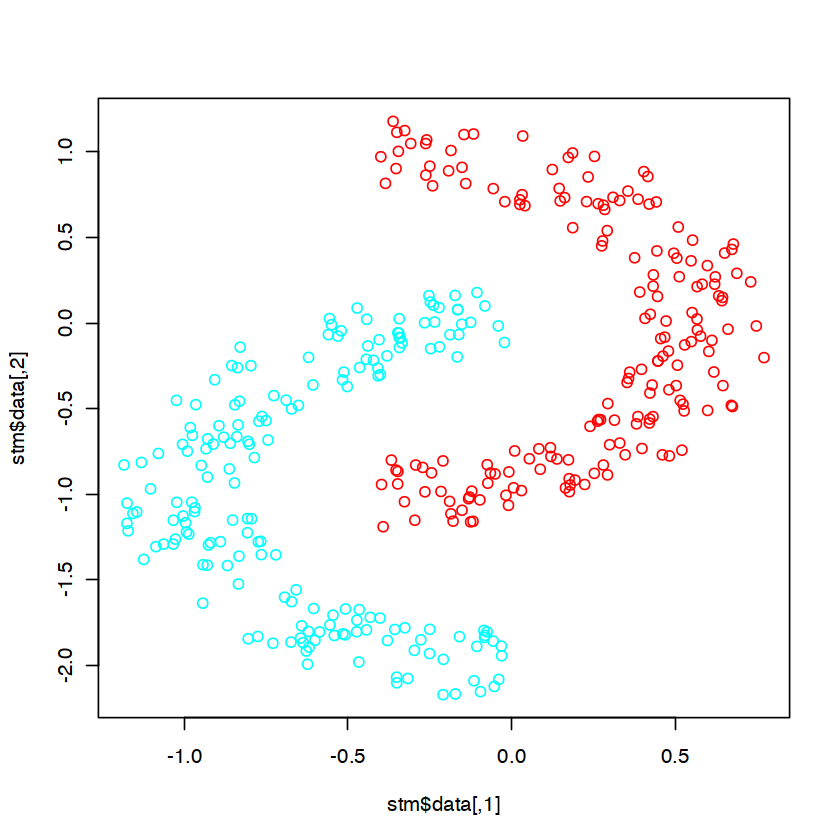

In [6]:
library(clusterSim)
stm <- shapes.two.moon(180)
plot(stm$data,col=rainbow(2)[stm$clusters])

# Splitting the data frame into train and test sets
set.seed(0)
sample_size <- floor(0.67 * nrow(stm$data))
train_idx <- sample(seq_len(nrow(stm$data)), size = sample_size)

X <- stm$data[train_idx,]
y <- as.numeric(stm$clusters[train_idx]==1) 
Xt  <- stm$data[-train_idx,]
yt  <- as.numeric(stm$clusters[-train_idx]==1)

In [8]:
weights = create_architecture(X, 3, 1)

n_epochs <- 1500
report_every_n <- 250

for (j in 1:n_epochs) {
    # First, feed forward through the hidden layer
    l <- feed_forward(X, weights)
    l1 <- l[[1]]
    l2 <- l[[2]]
    # Then, error backpropagation from output to input
    errors <- backpropagation(l1, l2, weights, y)
    l2_error <- errors[[1]] 
    l1_delta <- errors[[2]] 
    l2_delta <- errors[[3]]
    # Finally, updating the weights of the network
    weights <-  update_weights(X, l1, l1_delta, l2_delta, 
                               weights, alpha=0.05)
    if (((j %% report_every_n)==0) | (j==1)) {
        train_error <- mean(abs(l2_error))
        train_accuracy <- accuracy(true_label=y, 
                                  predicted=(l2 > 0.5))
        test_preds <- predict(Xt, weights)
        test_accuracy <- accuracy(true_label=yt, 
                                  predicted=test_preds)

        print(paste("Epoch", j, "- error", round(train_error, 4), 
                    "| accuracy: train", round(train_accuracy, 3), 
                    "/ test", round(test_accuracy, 3)))
    }
}

[1] "Epoch 1 - error 0.5143 | accuracy: train 0.502 / test 0.496"
[1] "Epoch 250 - error 0.1787 | accuracy: train 0.88 / test 0.891"
[1] "Epoch 500 - error 0.1735 | accuracy: train 0.876 / test 0.899"
[1] "Epoch 750 - error 0.1724 | accuracy: train 0.876 / test 0.899"
[1] "Epoch 1000 - error 0.1719 | accuracy: train 0.876 / test 0.899"
[1] "Epoch 1250 - error 0.1714 | accuracy: train 0.876 / test 0.899"
[1] "Epoch 1500 - error 0.1711 | accuracy: train 0.876 / test 0.899"
